# Member_Agreements (MA): Data Discovery, Preparation & Insights

### Target Attributes: member_id, agreement_type, StartDate, CancelDate, & Cancel Reason.

In [2]:
import sqlite3
from datetime import date
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

conn = sqlite3.connect(r"__PATH__")

df = pd.read_sql_query("SELECT * FROM member_agreements", conn)

### Data Understanding, Cleaning & Preparation

In [3]:
df.shape

(1000, 15)

In [4]:
df.head(2)

,agreement_row_id,member_id,First Name,Last Name,Agreement ID,Agreement Type,Sales Person,Promotion,Bundles,Payment Plan,StartDate,EXP/Oblig Date,CancelRequest,CancelDate,CancelReason
0,1,ABC1000,Angela,Brewer,AG-00001,Standard Annual,Sarah Lee,None,None,Annual,08/21/2024,09/20/2024,None,None,None
1,2,ABC1001,Jared,Sanchez,AG-00002,Standard M2M,John Smith,Summer Promo,None,Monthly,01/04/2024,12/31/2024,02/05/2024,12/02/2024,Relocation


In [5]:
df.columns, df.dtypes

(Index(['agreement_row_id', 'member_id', 'First Name', 'Last Name',
        'Agreement ID', 'Agreement Type', 'Sales Person', 'Promotion',
        'Bundles', 'Payment Plan', 'StartDate', 'EXP/Oblig Date',
        'CancelRequest', 'CancelDate', 'CancelReason'],
       dtype='object'),
 agreement_row_id     int64
 member_id           object
 First Name          object
 Last Name           object
 Agreement ID        object
 Agreement Type      object
 Sales Person        object
 Promotion           object
 Bundles             object
 Payment Plan        object
 StartDate           object
 EXP/Oblig Date      object
 CancelRequest       object
 CancelDate          object
 CancelReason        object
 dtype: object)

In [6]:
df = df[[
       #'agreement_row_id', 
       'member_id', 
       #'First Name', 'Last Name',
        #'Agreement ID', 
        'Agreement Type', 
        #'Sales Person', 'Promotion',
        #'Bundles', 'Payment Plan', 
        'StartDate', 
        #'EXP/Oblig Date',
        #'CancelRequest', 
        'CancelDate', 'CancelReason'
       ]].copy()

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df = df.rename(columns={
    'agreement type': 'agreement_type',
    'startdate': 'start_date',
    'canceldate': 'cancel_date',
    'cancelreason': 'cancel_reason'
        })

In [9]:
df.head(2), df.dtypes

(  member_id   agreement_type  start_date cancel_date cancel_reason
 0   ABC1000  Standard Annual  08/21/2024        None          None
 1   ABC1001     Standard M2M  01/04/2024  12/02/2024    Relocation,
 member_id         object
 agreement_type    object
 start_date        object
 cancel_date       object
 cancel_reason     object
 dtype: object)

In [10]:
df.isna().sum()

member_id           0
agreement_type      0
start_date          0
cancel_date       617
cancel_reason     637
dtype: int64

In [11]:
df['start_date'] = pd.to_datetime(df['start_date'])

In [12]:
# df['cancel_date'] = pd.to_datetime(df['cancel_date'])

df['cancel_date'] = df['cancel_date'].str.strip()
df['cancel_date'] = df['cancel_date'].replace('', np.nan) 
df['cancel_date'] = df['cancel_date'].replace(['none', 'NAN', 'nan'], np.nan)

df['cancel_date'] = pd.to_datetime(df['cancel_date'], errors='coerce')

In [13]:
df['cancel_reason'].value_counts()
df['cancel_reason'] = df['cancel_reason'].str.strip()
df['cancel_reason'] = df['cancel_reason'].replace(['', 'nan', 'NAN'], np.nan)
df['cancel_reason'] = df['cancel_reason'].str.title()
df['cancel_reason'].value_counts(dropna=False)

df['cancel_reason'] = df['cancel_reason'].where(pd.notnull(df['cancel_reason']), 'None')
df['cancel_reason'].value_counts(dropna=False)

cancel_reason
None                            686
Financial Reasons               107
Relocation                       81
Schedule Conflict                67
Dissatisfied With Facilities     59
Name: count, dtype: int64

### Check for duplicates

In [14]:
print(df.duplicated().sum())
print(df.duplicated(subset=['member_id']).sum())
print(df[df.duplicated(subset=['member_id'], keep=False)].sort_values(by='member_id').head(4))

0
0
Empty DataFrame
Columns: [member_id, agreement_type, start_date, cancel_date, cancel_reason]
Index: []


### Create Status Attribute for members based on if they have a cancellation date.

In [15]:
df['status'] = df['cancel_date'].isna().map({True: 'Active', False: 'Canceled'})

print(df['status'].value_counts())

status
Active      682
Canceled    318
Name: count, dtype: int64


In [16]:
df[df['member_id'] == 'ABC1003']

,member_id,agreement_type,start_date,cancel_date,cancel_reason,status
3,ABC1003,Standard M2M,2023-11-02,NaT,None,Active


### Calculate Tenure Days for all Members (across lifetime)

In [17]:

today = pd.Timestamp.today().normalize()

df['tenure_days'] = df.apply(
    lambda row: (row['cancel_date'] - row['start_date']).days 
                if pd.notnull(row['cancel_date']) 
                else (today - row['start_date']).days,
    axis=1
)
df.head(2)

,member_id,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days
0,ABC1000,Standard Annual,2024-08-21,NaT,None,Active,379
1,ABC1001,Standard M2M,2024-01-04,2024-12-02,Relocation,Canceled,333


In [18]:
df.head(10)

,member_id,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days
0,ABC1000,Standard Annual,2024-08-21,NaT,None,Active,379
1,ABC1001,Standard M2M,2024-01-04,2024-12-02,Relocation,Canceled,333
2,ABC1002,Standard M2M,2024-02-19,NaT,Relocation,Active,563
3,ABC1003,Standard M2M,2023-11-02,NaT,None,Active,672
4,ABC1004,Standard M2M,2023-09-12,NaT,None,Active,723
5,ABC1005,Standard M2M,2023-12-08,NaT,None,Active,636
6,ABC1006,Standard M2M,2025-06-24,2025-07-10,Schedule Conflict,Canceled,16
7,ABC1007,Standard M2M,2025-07-25,NaT,None,Active,41
8,ABC1008,Standard M2M,2025-01-19,NaT,Dissatisfied With Facilities,Active,228
9,ABC1009,Standard M2M,2024-02-20,NaT,None,Active,562


### 105day flag.

In [19]:
cutoff = 105

# -------------------------------------------------------------------
# eligible_105 flag
# -------------------------------------------------------------------
# Purpose:
#   - Exclude "immature actives" (those with tenure < 105 days who have
#              not yet had enough time to show churn/retention behavior).
#   - Keep all canceled members (no matter when they canceled).
#   - Keep active members only if they have been observed for at least 105 days.
#
# Result:
#   - eligible_105 = 1 → member is valid for churn analysis
#   - eligible_105 = 0 → member is too new (active < 105 days)

df['eligible_105'] = np.where(
    (df['status'] == 'Canceled') | ((df['status'] == 'Active') & (df['tenure_days'] >= cutoff)),
    1, 0
)

# -------------------------------------------------------------------
# churn_by_105 flag
# -------------------------------------------------------------------
# Purpose:
#   - Identify members who canceled within the first 105 days of tenure.
#   - This is your "early churn" outcome variable for predictive analysis.
#
# Result:
#   - churn_by_105 = 1 → member canceled within 105 days
#   - churn_by_105 = 0 → member either:
#       * canceled after 105 days (late churn), OR
#       * is still active (no churn event yet)

# churn event: 1 if canceled within 105 days
df['churn_by_105'] = np.where(
    (df['status'] == 'Canceled') &
    ((df['cancel_date'] - df['start_date']).dt.days <= cutoff),
    1, 0
)

In [20]:
df.head(20)

,member_id,agreement_type,start_date,cancel_date,cancel_reason,status,tenure_days,eligible_105,churn_by_105
0,ABC1000,Standard Annual,2024-08-21,NaT,None,Active,378,1,0
1,ABC1001,Standard M2M,2024-01-04,2024-12-02,Relocation,Canceled,333,1,0
2,ABC1002,Standard M2M,2024-02-19,NaT,Relocation,Active,562,1,0
3,ABC1003,Standard M2M,2023-11-02,NaT,None,Active,671,1,0
4,ABC1004,Standard M2M,2023-09-12,NaT,None,Active,722,1,0
5,ABC1005,Standard M2M,2023-12-08,NaT,None,Active,635,1,0
6,ABC1006,Standard M2M,2025-06-24,2025-07-10,Schedule Conflict,Canceled,16,1,1
7,ABC1007,Standard M2M,2025-07-25,NaT,None,Active,40,0,0
8,ABC1008,Standard M2M,2025-01-19,NaT,Dissatisfied With Facilities,Active,227,1,0
9,ABC1009,Standard M2M,2024-02-20,NaT,None,Active,561,1,0


### Load to clean_db

In [ ]:
con_out = sqlite3.connect(r"__PATH__")
df.to_sql("member_agreements", con_out, if_exists="replace", index=False)
con_out.close()

## Exploration

### Average Sales v. Cancellations per Month.

In [23]:
# Extract year and month
df['start_year'] = df['start_date'].dt.year
df['start_month'] = df['start_date'].dt.month
df['cancel_year'] = df['cancel_date'].dt.year
df['cancel_month'] = df['cancel_date'].dt.month

# Count starts and cancels by year & month
starts = df.groupby(['start_year', 'start_month']).size().unstack(fill_value=0)
cancels = df.groupby(['cancel_year', 'cancel_month']).size().unstack(fill_value=0)

# Total starts by month across years
starts_by_month = df.groupby('start_month').size()

# Total cancels by month across years
cancels_by_month = df.groupby('cancel_month').size()

# Combine
seasonality = pd.DataFrame({
    'Starts': starts_by_month,
    'Cancels': cancels_by_month
}).fillna(0).astype(int)

months = range(1, 13)

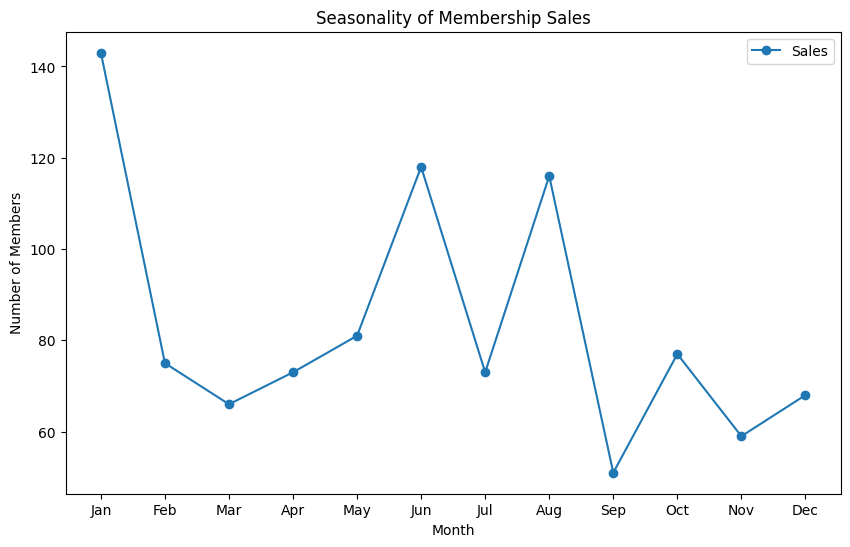

In [24]:
plt.figure(figsize=(10,6))
plt.plot(months, seasonality['Starts'], marker='o', label='Sales')

plt.xticks(months, ['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title("Seasonality of Membership Sales")
plt.xlabel("Month")
plt.ylabel("Number of Members")
plt.legend()
plt.show()

### Tenure for canceled members

In [45]:
median_tenure = df.loc[df['status'] == 'Canceled', 'tenure_days'].median()
# AVG Cancellation Tenure
print(f"Median tenure before cancellation: {median_tenure:.0f} days")

Median tenure before cancellation: 105 days


### Member Retention Rate for Cancelled Members

In [46]:
# 1) Filter to canceled members only
canceled_mask = df['cancel_date'].notna()  # or: df['status'].eq('Canceled')
cdf = df.loc[canceled_mask].copy()

# 2) Recompute retention flags on *canceled-only*
thresholds = [30, 60, 90, 120]
for t in thresholds:
    cdf[f'retention_{t}d'] = (cdf['tenure_days'] >= t).astype(int)

# 3) Compute rates (among canceled only)
retention_rates_canceled = {t: cdf[f'retention_{t}d'].mean() for t in thresholds}

for t, rate in retention_rates_canceled.items():
    print(f"{t}-day retention: {rate:.2%}, churn: {1-rate:.2%}")

# Convert retention_rates dict into lists
days = list(retention_rates_canceled.keys())
rates = [rate*100 for rate in retention_rates_canceled.values()]  # convert to %

# Calculate churn rates
churn_rates = [(1 - rate) * 100 for rate in retention_rates_canceled.values()]  # convert to %

30-day retention: 78.93%, churn: 21.07%
60-day retention: 65.09%, churn: 34.91%
90-day retention: 55.66%, churn: 44.34%
120-day retention: 43.71%, churn: 56.29%


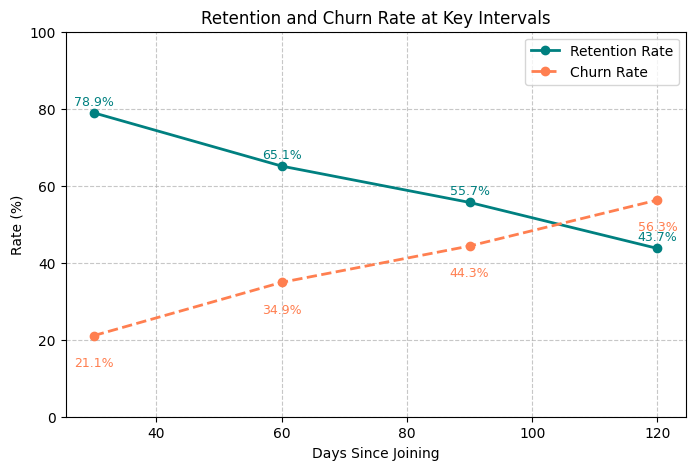

In [48]:
plt.figure(figsize=(8,5))
plt.plot(days, rates, marker='o', linestyle='-', color='teal', linewidth=2, label='Retention Rate')
plt.plot(days, churn_rates, marker='o', linestyle='--', color='coral', linewidth=2, label='Churn Rate')

# Labels & titles
plt.title('Retention and Churn Rate at Key Intervals')
plt.xlabel('Days Since Joining')
plt.ylabel('Rate (%)')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Show values on points
for x, y in zip(days, rates):
    plt.text(x, y+2, f"{y:.1f}%", ha='center', fontsize=9, color='teal')
for x, y in zip(days, churn_rates):
    plt.text(x, y-8, f"{y:.1f}%", ha='center', fontsize=9, color='coral')

plt.show()

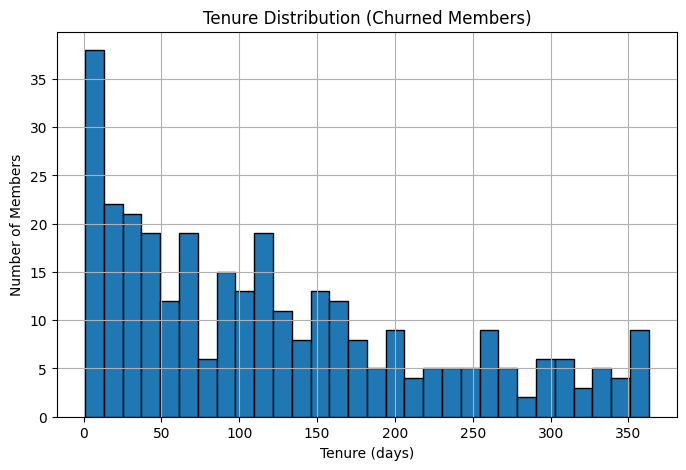

In [49]:
# Histogram of tenure
plt.figure(figsize=(8,5))
df.loc[df['status'] == 'Canceled', 'tenure_days'].hist(bins=30, edgecolor='black')
plt.title('Tenure Distribution (Churned Members)')
plt.xlabel('Tenure (days)')
plt.ylabel('Number of Members')
plt.show()

### Cancellation Reasons

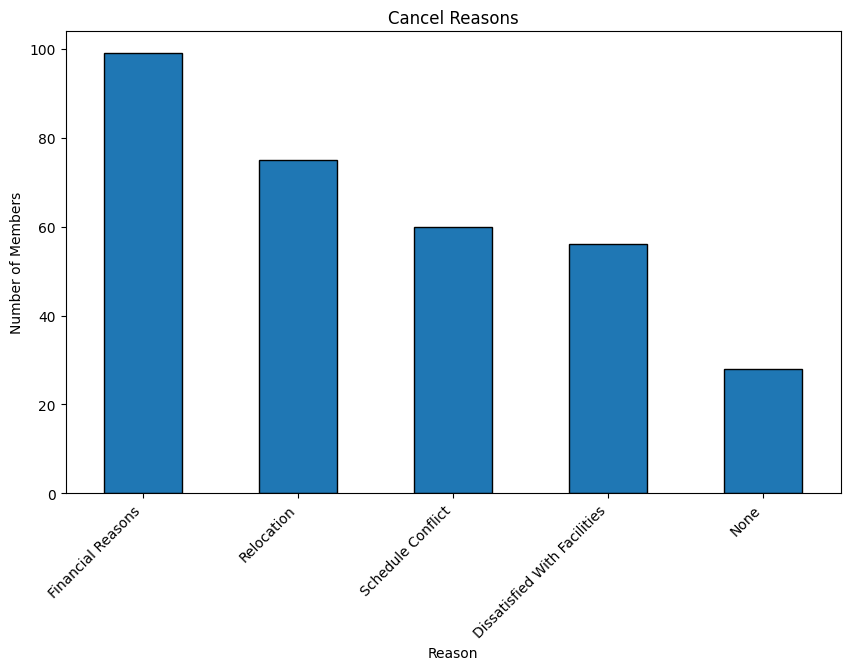

In [29]:
# Count cancellation reasons (including 'None')
cancel_reason = (
    df.groupby('cancel_reason')['status'].apply(lambda x: (x == 'Canceled').sum())
    .sort_values(ascending=False)
)

# Bar chart of cancel reasons
plt.figure(figsize=(10,6))
cancel_reason.plot(
    kind='bar',
    edgecolor='black'
)
plt.title('Cancel Reasons')
plt.xlabel('Reason')
plt.ylabel('Number of Members')
plt.xticks(rotation=45, ha='right')
plt.show()

### Cancellation by Agreement Table

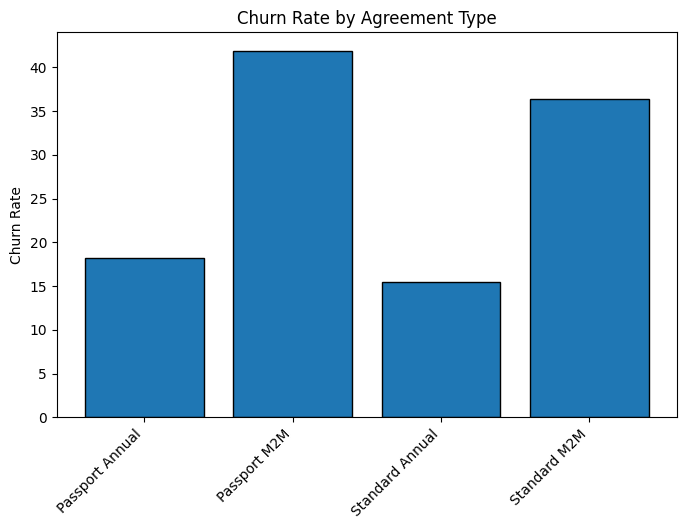

,agreement_type,churn_rate
0,Passport Annual,18.181818
1,Passport M2M,41.911765
2,Standard Annual,15.476190
3,Standard M2M,36.348409


In [30]:
# Churn rate by agreement type
churn_by_agreement = (
    df.groupby('agreement_type')['status']
    .apply(lambda x: (x=='Canceled').mean() * 100)
    .reset_index(name='churn_rate')
)

plt.figure(figsize=(8,5))
plt.bar(churn_by_agreement['agreement_type'], churn_by_agreement['churn_rate'], edgecolor='black')
plt.title('Churn Rate by Agreement Type')
plt.ylabel('Churn Rate')
plt.xticks(rotation=45, ha='right')
plt.show()

churn_by_agreement

In [31]:
# Summarize retention (use canceled members only)
retention_summary = (
    cdf.groupby("agreement_type")[["retention_30d","retention_60d","retention_90d","retention_120d"]]
      .mean()   # mean of 0/1 columns = retention rate
      .reset_index()
)

# Add churn columns (just 1 - retention)
for col in ["retention_30d","retention_60d","retention_90d","retention_120d"]:
   churn_col = col.replace("retention","churn")
   retention_summary[churn_col] = 1 - retention_summary[col]

retention_summary

,agreement_type,retention_30d,retention_60d,retention_90d,retention_120d,churn_30d,churn_60d,churn_90d,churn_120d
0,Passport Annual,0.611111,0.444444,0.388889,0.222222,0.388889,0.555556,0.611111,0.777778
1,Passport M2M,0.754386,0.649123,0.543860,0.403509,0.245614,0.350877,0.456140,0.596491
2,Standard Annual,0.769231,0.576923,0.500000,0.307692,0.230769,0.423077,0.500000,0.692308
3,Standard M2M,0.815668,0.677419,0.580645,0.479263,0.184332,0.322581,0.419355,0.520737


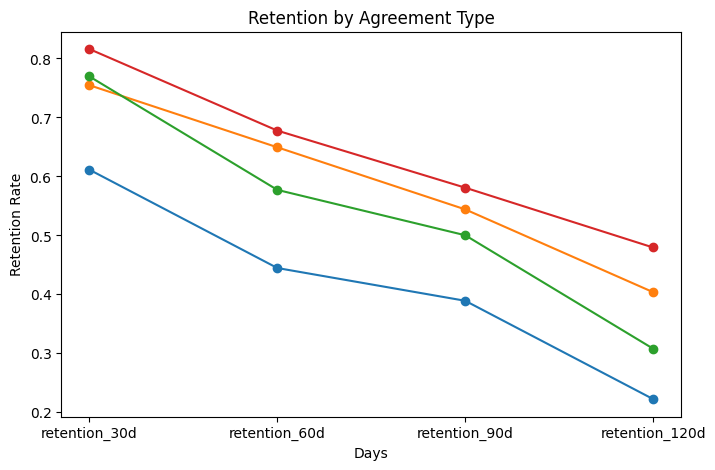

In [32]:
plt.figure(figsize=(8,5))
plt.plot(retention_summary.set_index("agreement_type")[
    ["retention_30d","retention_60d","retention_90d","retention_120d"]].T, marker='o')
plt.title("Retention by Agreement Type")
plt.ylabel("Retention Rate")
plt.xlabel("Days")
plt.show()